In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import loompy
import anndata
from matplotlib import rcParams

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
sc.settings.verbosity = 3     
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
adata = sc.read_loom('good.loom', X_name='spliced', obs_names='cellID', var_names='GeneName', dtype='float32',validate=False)
adata.obs_names_make_unique() 

#cellType: mesenchymal, immune, endothelial, epithelial
#endothelial: Early Car4- capillaries, Car4+ caplillaries
#Pericyte

interaction=pd.read_csv('interaction_unpacked_mouse.tsv',sep='\t')[['gene_name_mouse_a','gene_name_mouse_b']]

scanpy==1.9.1 anndata==0.7.5 umap==0.4.6 numpy==1.21.2 scipy==1.5.3 pandas==1.5.2 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.9.9 louvain==0.7.0 leidenalg==0.8.1


In [3]:
# adata.obsm['X_umap']=adata.obs[['embed_endo_1','embed_endo_2']].values
# adata_endo=adata[adata.obs['cellType']=='endothelial']
# sc.pp.log1p(adata_endo)

# sc.pl.umap(adata_endo,color='cellSubtype',
#            palette=['#bd4f6f','#ee4242', '#3ab646','#a6bd4f','#4fbd9d', 
#                     '#ffda4f', '#7d7d7d', '#664fbd','#1e1e1e','#4380c9'])

# adata_im = adata[adata.obs['cellType'] == 'immune']
# sc.pp.log1p(adata_im)

### What I did while doing the project

In [50]:
adata_pericyte=adata[adata.obs['cellSubtype']=='Pericyte']
adata_car4=adata[adata.obs['cellSubtype']=='Car4+ capillaries']
adata_early_car4=adata[adata.obs['cellSubtype']=='Early Car4- capillaries']

In [147]:
def n_interactions(adata_pericyte, adata_car4, adata_early_car4, threshold, timepoint):
    result_peri_car4=[]
    result_peri_peri=[]
    result_peri_early_Car4=[]

    for _,row in interaction.iterrows(): 
        gene_a=row[0]
        gene_b=row[1]

        if (gene_a not in adata.var_names) | (gene_b not in adata.var_names):
            continue

        frac_peri_a=(adata_pericyte[:,gene_a].X.toarray()[:,0]>0).mean()
        frac_peri_b=(adata_pericyte[:,gene_b].X.toarray()[:,0]>0).mean()
        frac_car4_a=(adata_car4[:,gene_a].X.toarray()[:,0]>0).mean()
        frac_car4_b=(adata_car4[:,gene_b].X.toarray()[:,0]>0).mean()
        frac_early_car4_a=(adata_early_car4[:,gene_a].X.toarray()[:,0]>0).mean()
        frac_early_car4_b=(adata_early_car4[:,gene_b].X.toarray()[:,0]>0).mean()

        table=np.array([[frac_peri_a,frac_peri_b], # pericyte
                        [frac_car4_a,frac_car4_b], # car4+ capillaries
                        [frac_early_car4_a,frac_early_car4_b]]) # early car4- capillaries
        
        #### pericyte with gene a
        if table[0,0]>threshold and table[1,1]>threshold:
            result_peri_car4.append([gene_a,gene_b,table[0,0],table[1,1],'Pericyte','Car4+ capillaries'])
            
        if table[0,0]>threshold and table[2,1]>threshold:
            result_peri_early_Car4.append([gene_a,gene_b,table[0,0],table[2,1],'Pericyte','Early Car4- capillaries'])

        ##### Car4+ with gene a
        if table[1,0]>threshold and table[0,1]>threshold:
            #result_peri_car4.append([gene_a,gene_b,table[1,0],table[0,1],'Car4+ capillaries','Pericyte'])
            result_peri_car4.append([gene_b,gene_a,table[0,1],table[1,0],'Pericyte','Car4+ capillaries'])

        #### Car4- with gene a
        if table[2,0]>threshold and table[0,1]>threshold:
            #result_peri_early_Car4.append([gene_a,gene_b,table[2,0],table[0,1],'Early Car4- capillaries','Pericyte'])
            result_peri_early_Car4.append([gene_b,gene_a,table[0,1],table[2,0],'Pericyte','Early Car4- capillaries'])

        #### pericyte with pericyte
        if table[0,0]>threshold and table[0,1]>threshold:
            result_peri_peri.append([gene_a,gene_b,table[0,0],table[0,1],'Pericyte','Pericyte'])
            result_peri_peri.append([gene_b,gene_a,table[0,1],table[0,0],'Pericyte','Pericyte'])

    result_peri_car4=pd.DataFrame(result_peri_car4,columns=['Gene_a','Gene_b','Frac_Gene_a','Frac_Gene_b','Cell_express_a','Cell_express_b'])
    result_peri_peri=pd.DataFrame(result_peri_peri,columns=['Gene_a','Gene_b','Frac_Gene_a','Frac_Gene_b','Cell_express_a','Cell_express_b'])
    result_peri_early_Car4=pd.DataFrame(result_peri_early_Car4,columns=['Gene_a','Gene_b','Frac_Gene_a','Frac_Gene_b','Cell_express_a','Cell_express_b'])
    
    result_peri_car4.to_csv(f'excels/{timepoint}_result_peri_car4.tsv', sep='\t', index=False)
    result_peri_peri.to_csv(f'excels/{timepoint}_result_peri_peri.tsv', sep='\t', index=False)
    result_peri_early_Car4.to_csv(f'excels/{timepoint}_result_peri_early_car4.tsv', sep='\t', index=False)

In [ ]:
# all timepoints
n_interactions(adata_pericyte, adata_car4, adata_early_car4, 0.1, '') 

In [84]:
if False:
    pairs_Car4=[['Itgb1','Col4a1'],['Itgb1','Col1a2'],['Itgb1','Col4a2'],['Itgb1','Col1a1'],
                ['Plaur','Itgb1'],['Plaur','Itga4'],['Plaur','Itgav'],
                ['Fbn1','Itgb1'],['Fbn1','Itga5'],
                ['Nectin3','Cadm1'],
                ['Itgb1','Lamc1'],
                ['Itgb1','Cspg4'],
                ['Pdgfb','Pdgfrb'],
                ['Sirpa','Cd47'],
                ['Sema7a','Itgb1']
               ]
    pairs_Early_Car4=[['Col15a1','Itga1'],['Col15a1','Itgb1'],['Col18a1','Itga1'],['Col18a1','Itgb1'],
                      ['Dll1','Notch1'],['Dll1','Notch2'],['Dll1','Notch3'],['Dll1','Notch4'],
                      ['Cxcl12','Cxcr4'],
                      ['Bmp6','Bmpr2'],['Bmp6','Acvr2a'],['Bmp6','Bmpr1a'],['Bmp6','Acvr1'],['Bmp6','Acvr2b'],
                      ['Fzd6','Wnt5a'],['Fzd6','Wnt4'],['Fzd3','Wnt5a'],
                      ['Gas6','Axl'],['Il15ra','Axl'],['Il15ra','Il15'],
                      ['Clcf1','Il6st'],['Clcf1','Lifr']
                     ]
    pairs_pericyte=[['Cadm1','Cadm1'],
                    ['Cd44','Hbegf'],['Cd44','Hgf'],['Cd44','Spp1'],
                    ['Wnt5a','Fzd1'],['Wnt4','Fzd1'],
                    ['Bmpr1a','Bmp2'],['Bmpr1a','Bmp4'],['Bmpr1a','Bmp5'],
                    ['Wnt5a','Ror1'],['Wnt4','Smo'],['Bmp2','Smo'],
                    ['Fn1','Itga8'],['Tnc','Itga8'],
                    ['Spp1','Itga9'],['Tnc','Itga9'],
                    ['Nrp2','Pgf'],['Nrp1','Pgf']
                   ]

    pairs_dic={'Car4+ capillaries':pairs_Car4,'Early Car4- capillaries':pairs_Early_Car4,'Pericyte':pairs_pericyte}
    pairs_cts=[['Car4+ capillaries','Pericyte'],['Early Car4- capillaries','Pericyte'],['Pericyte','Pericyte']]
    adata_dic={'Pericyte':adata_pericyte,'Car4+ capillaries':adata_car4,'Early Car4- capillaries':adata_early_car4}

    ##### cumulative plots
    for ct1,ct2 in pairs_cts:
        pairs=pairs_dic[ct1]

        for gene1,gene2 in pairs:
            fig,ax=plt.subplots(figsize=(6,3))
            gene1_ct1=adata_dic[ct1][:,gene1].X.toarray()[:,0]
            gene1_ct1=np.log10(0.1+gene1_ct1)
            x=np.sort(gene1_ct1)
            y=1-np.linspace(0,1,len(x))
            ax.plot(x,y,label=gene1+ ' in ' +ct1,lw=2)

            gene2_ct2=adata_dic[ct2][:,gene2].X.toarray()[:,0]
            gene2_ct2=np.log10(0.1+gene2_ct2)
            x=np.sort(gene2_ct2)
            y=1-np.linspace(0,1,len(x))
            ax.plot(x,y,label=gene2+ ' in ' +ct2,lw=2)

            ax.set_xlabel('gene expression [log10(cpm+0.1)]',fontsize=10)
            ax.tick_params(labelsize=10)
            ax.set_ylabel('fract of cells expressing ≥ x',fontsize=10)
            ax.legend(loc='upper left',bbox_to_anchor=(1,1),bbox_transform=ax.transAxes,fontsize=10)
            #ax.grid(False)
            fig.tight_layout()
    #         fig.savefig('figures/interaction_endo_peri/cul/'+gene1+' in '+ct1+' & '+gene2+' in '+ct2+'_cumul.png')
    
    # kde plots
    for ct1,ct2 in pairs_cts:
        pairs=pairs_dic[ct1]
    
        for gene1,gene2 in pairs:
            fig,ax=plt.subplots(figsize=(6,3))
            gene1_ct1=adata_dic[ct1][:,gene1].X.toarray()[:,0]
            gene1_ct1=np.log10(0.1+gene1_ct1)
            sns.kdeplot(gene1_ct1,ax=ax,bw=0.1,label=gene1+ ' in ' +ct1,lw=2)

            gene2_ct2=adata_dic[ct2][:,gene2].X.toarray()[:,0]
            gene2_ct2=np.log10(0.1+gene2_ct2)
            sns.kdeplot(gene2_ct2,ax=ax,bw=0.1,label=gene2+ ' in ' +ct2,lw=2)

            ax.set_xlabel('gene expression [log10(cpm+0.1)]',fontsize=10)
            ax.set_ylabel('density of cells',fontsize=10)
            ax.tick_params(labelsize=10)
            ax.legend(loc='upper left',bbox_to_anchor=(1,1),bbox_transform=ax.transAxes,fontsize=10)
            #ax.grid(False)
            fig.tight_layout()
            #fig.savefig('figures/interaction_endo_peri/kde/'+gene1+' in '+ct1+' & '+gene2+' in '+ct2+'.png')

### The following are for theis, Car4- capillaries include both early and late

In [19]:
def inters_df(adata_d, ecs, mcs, threshold, timepoint):
    res = []

    for _,row in interaction.iterrows(): 
        gene_a=row[0]
        gene_b=row[1]

        if (gene_a not in adata.var_names) | (gene_b not in adata.var_names):
            continue

            
        for ec in ecs:
            for mc in mcs:
                frac_ec_a = (adata_d[ec, timepoint][:,gene_a].X.toarray()[:,0]>0).mean()
                frac_ec_b = (adata_d[ec, timepoint][:,gene_b].X.toarray()[:,0]>0).mean()
                frac_mc_a = (adata_d[mc, timepoint][:,gene_a].X.toarray()[:,0]>0).mean()
                frac_mc_b = (adata_d[mc, timepoint][:,gene_b].X.toarray()[:,0]>0).mean()

                table = np.array([[frac_ec_a,frac_ec_b], # pericyte
                                [frac_mc_a,frac_mc_b], # car4+ capillaries
                               ]) 

                #### pericyte with pericyte
                if table[0,0] >= threshold and table[0,1] >= threshold:
                    res.append([gene_a,gene_b,table[0,0],table[0,1],ec,ec])

                #### pericyte with gene a
                if table[0,0] >= threshold and table[1,1] >= threshold:
                    res.append([gene_a,gene_b,table[0,0],table[1,1],ec,mc])

                ##### Car4+ with gene a
                if table[1,0] >= threshold and table[0,1] >= threshold:
                    res.append([gene_b,gene_a,table[0,1],table[1,0],ec,mc])

                ##### Car4+ with Car4+
                if table[1,0] >= threshold and table[1,1] >= threshold:
                    res.append([gene_b,gene_a,table[1,1],table[1,0],mc, mc])

    res_df = pd.DataFrame(res,columns=['Gene_a','Gene_b','Frac_Gene_a','Frac_Gene_b','Cell_express_a','Cell_express_b'])
    
    return res_df

In [60]:
## get cell subtypes at different timepoints

timepoints=['E18.5', 'P1', 'P7', 'P21', 'P7_HO']
adata_d={}
for timepoint in timepoints:
    
    # 'Pericyte', 'Arterial EC', 'Venous EC', 'Lymphatic EC'
    for ct, cts in zip(['Pericyte', 'Arterial EC', 'Venous EC', 'Lymphatic EC',], 
                       [['Pericyte'], ['Arterial EC I', 'Arterial EC II'], ['Venous EC'], ['Lymphatic EC']]):
        key=(ct,timepoint)
        adata_d[key] = adata[(adata.obs['cellSubtype'].isin(cts)) &
                             (adata.obs['TimepointHO'] == timepoint)]

    # Car4+ capillaries
    if timepoint == 'E18.5':
        key=('Car4+ capillaries',timepoint)
        adata_d[key] = adata[(adata.obs['cellSubtype'].isin(['Nonproliferative embryonic EC'])) &
                             (adata.obs['TimepointHO'] == timepoint)]
    else:
        key = ('Car4+ capillaries',timepoint)
        adata_d[key] = adata[(adata.obs['cellSubtype'].isin(['Car4+ capillaries'])) &
                             (adata.obs['TimepointHO'] == timepoint)]
    
    # Car4- capillaries
    if timepoint == 'E18.5':
        key=('Car4- capillaries',timepoint)
        adata_d[key] = adata[(adata.obs['cellSubtype'].isin(['Nonproliferative embryonic EC'])) &
                             (adata.obs['TimepointHO'] == timepoint)]
    elif timepoint == 'P21':
        key = ('Car4- capillaries',timepoint)
        adata_d[key] = adata[(adata.obs['cellSubtype'].isin(['Late Car4- capillaries'])) &
                             (adata.obs['TimepointHO'] == timepoint)]
    else:
        key = ('Car4- capillaries',timepoint)
        adata_d[key] = adata[(adata.obs['cellSubtype'].isin(['Early Car4- capillaries'])) &
                             (adata.obs['TimepointHO'] == timepoint)]

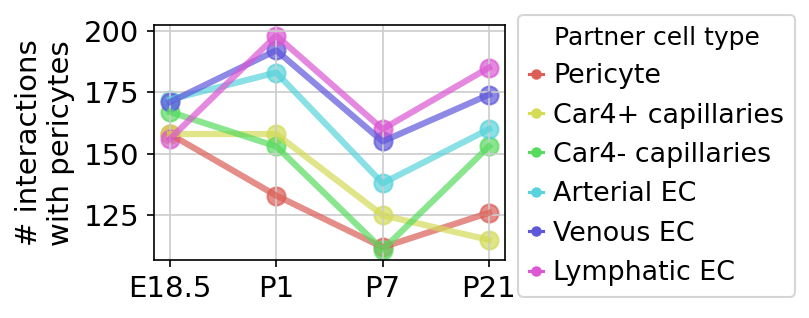

In [70]:
# compute interactions at different timepoints with threshold as 20 %
ecs = ['Car4+ capillaries', 'Car4- capillaries', 'Pericyte', 'Arterial EC', 'Venous EC', 'Lymphatic EC']
mcs = ['Pericyte']
path = '/home/yike/phd/neonatal_lung/jupyter notebook/excels/thesis/'
for tmpt in ['E18.5', 'P1', 'P7', 'P21']:
    resi = inters_df(adata_d, ecs, mcs, 0.2, tmpt)
    resi.to_csv(path + 'pericyte_' + tmpt + '.tsv',
              sep='\t', index=False)
    
# number of interactions
n = [] # pericyte, car4+, early car4-
path = 'excels/thesis/'
ecs = ['Car4+ capillaries', 'Car4- capillaries', 'Pericyte', 'Arterial EC', 'Venous EC', 'Lymphatic EC']

for tmpt in ['E18.5', 'P1', 'P7', 'P21']:
    df = pd.read_csv(path + f'pericyte_{tmpt}.tsv', sep='\t',).set_index(['Cell_express_a', 'Cell_express_b'])
    ni = []
    for ec in ecs:
        dfi = df.loc[ec, 'Pericyte']
        ni.append(dfi[~ dfi.duplicated()].shape[0])
    n.append(ni)

# plot number of interactions
import matplotlib.lines as mlines
rcParams['font.size'] = 12

fig, ax = plt.subplots(figsize=[3, 2], dpi=150)
colors = sns.color_palette('hls', 6)

handles = []
labels = ['Pericyte', 'Car4+ capillaries', 'Car4- capillaries', 'Arterial EC', 'Venous EC', 'Lymphatic EC']
for i, ct in enumerate(labels):
    ax.plot(range(4), np.array(n)[:, i], color=colors[i], lw=3, alpha=0.7)
    ax.scatter(range(4), np.array(n)[:, i], color=colors[i], s=75, alpha=0.7)

    handles.append(mlines.Line2D([], [], color=colors[i], marker='.',
                          markersize=8, label=ct))

ax.legend(title='Partner cell type', handles=handles, labels=labels, 
          bbox_to_anchor=[1, 1.1], bbox_transform=ax.transAxes)

ax.set_xticks(range(4))
ax.set_xticklabels(['E18.5', 'P1', 'P7', 'P21'])
ax.set_ylabel('# interactions\nwith pericytes')
plt.savefig('/home/yike/phd/YK_thesis/chapter3_figures/ninters_tmpt2.png', bbox_inches='tight')

### heatmap

In [243]:
# cell types at E18.5
mcs1 = ['Pericyte', 
       'Myofibroblast and smooth muscle precursor',
       'Fibroblast precursor', 
       'Vascular smooth muscle',
]

ecs1 = ['Nonproliferative embryonic EC',
       'Arterial EC', 
       'Venous EC', 
       'Lymphatic EC',
]

adata_d1 = {}
tmpt = 'E18.5'
for ct in mcs1 + ecs1:
    if ct == 'Arterial EC':
        adata_d1[ct, tmpt] = adata[(adata.obs['cellSubtype'].isin(['Arterial EC I', 'Arterial EC II'])) & 
                                  (adata.obs['TimepointHO'] == tmpt)]
    else:
        adata_d1[ct, tmpt] = adata[(adata.obs['cellSubtype'] == ct) & 
                                      (adata.obs['TimepointHO'] == tmpt)]

res1 = inters_df(adata_d1, mcs1, mcs1+ecs1, 0.2, tmpt)
res1.to_csv(path + tmpt + '0.2.tsv', sep='\t', index=False)

In [244]:
# cell types at P1
mcs2 = ['Pericyte', 
       'Myofibroblast', 'Early airway smooth muscle', 
       'Early alveolar fibroblast', 'Early adventitial fibroblast', 
       'Vascular smooth muscle',
]

ecs2 = ['Car4+ capillaries',
       'Early Car4- capillaries',
       'Arterial EC', 
       'Venous EC', 
       'Lymphatic EC',
]

adata_d2 = {}
tmpt = 'P1'
for ct in mcs2 + ecs2:
    if ct == 'Arterial EC':
        adata_d2[ct, tmpt] = adata[(adata.obs['cellSubtype'].isin(['Arterial EC I', 'Arterial EC II'])) & 
                                  (adata.obs['TimepointHO'] == tmpt)]
    else:
        adata_d2[ct, tmpt] = adata[(adata.obs['cellSubtype'] == ct) & 
                                      (adata.obs['TimepointHO'] == tmpt)]

res2 = inters_df(adata_d2, mcs2, mcs2+ecs2, 0.2, tmpt)
res2.to_csv(path + tmpt + '0.2.tsv', sep='\t', index=False)

In [245]:
# cell types at P7
mcs3 = ['Pericyte', 
       'Myofibroblast', 'Early airway smooth muscle', 
       'Early alveolar fibroblast', 'Early adventitial fibroblast', 
       'Vascular smooth muscle',
]

ecs3 = ['Car4+ capillaries',
       'Early Car4- capillaries',
       'Arterial EC', 
       'Venous EC', 
       'Lymphatic EC',
]

adata_d3 = {}
tmpt = 'P7'
for ct in mcs3 + ecs3:
    if ct == 'Arterial EC':
        adata_d3[ct, tmpt] = adata[(adata.obs['cellSubtype'].isin(['Arterial EC I', 'Arterial EC II'])) & 
                                  (adata.obs['TimepointHO'] == tmpt)]
    else:
        adata_d3[ct, tmpt] = adata[(adata.obs['cellSubtype'] == ct) & 
                                      (adata.obs['TimepointHO'] == tmpt)]

res3 = inters_df(adata_d3, mcs3, mcs3+ecs3, 0.2, tmpt)
res3.to_csv(path + tmpt + '0.2.tsv', sep='\t', index=False)

In [246]:
# cell types at P21
mcs4 = ['Pericyte', 
       'Airway smooth muscle', 
       'Alveolar fibroblast', 'Adventitial fibroblast', 
       'Vascular smooth muscle',
]

ecs4 = ['Car4+ capillaries',
       'Late Car4- capillaries',
       'Arterial EC', 
       'Venous EC', 
       'Lymphatic EC',
]

adata_d4 = {}
tmpt = 'P21'
for ct in mcs4 + ecs4:
    if ct == 'Arterial EC':
        adata_d4[ct, tmpt] = adata[(adata.obs['cellSubtype'].isin(['Arterial EC I', 'Arterial EC II'])) & 
                                  (adata.obs['TimepointHO'] == tmpt)]
    else:
        adata_d4[ct, tmpt] = adata[(adata.obs['cellSubtype'] == ct) & 
                                      (adata.obs['TimepointHO'] == tmpt)]

res4 = inters_df(adata_d4, mcs4, mcs4+ecs4, 0.2, tmpt)
res4.to_csv(path + tmpt + '0.2.tsv', sep='\t', index=False)

In [103]:
def get_fdn(tmpt, mcs, ecs):
    path = 'excels/thesis/'
    df = pd.read_csv(path + tmpt + '.tsv', sep='\t', index_col=['Cell_express_a', 'Cell_express_b'])

    dfn = pd.DataFrame([], columns=mcs+ecs, index=mcs)
    for mc in mcs:
        for ct in mcs + ecs:
            i = df.loc[mc, ct][~ df.loc[mc, ct].duplicated()].shape[0]
            dfn.at[mc, ct] = i 
    dfn = dfn.apply(pd.to_numeric)
    
    return dfn

In [138]:
dfn1 = get_fdn('E18.5', mcs1, ecs1)
dfn2 = get_fdn('P1', mcs2, ecs2)
dfn3 = get_fdn('P7', mcs3, ecs3)
dfn4 = get_fdn('P21', mcs4, ecs4)

<ipython-input-103-a563cc048f88>:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  i = df.loc[mc, ct][~ df.loc[mc, ct].duplicated()].shape[0]
<ipython-input-103-a563cc048f88>:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  i = df.loc[mc, ct][~ df.loc[mc, ct].duplicated()].shape[0]
<ipython-input-103-a563cc048f88>:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  i = df.loc[mc, ct][~ df.loc[mc, ct].duplicated()].shape[0]
<ipython-input-103-a563cc048f88>:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  i = df.loc[mc, ct][~ df.loc[mc, ct].duplicated()].shape[0]


In [210]:
def plot_ninters(dfn, mcs, ecs, tmpt, threshold):
    ### index
    from scipy.spatial.distance import pdist 
    distance = pdist(dfn[mcs].values)
    from scipy.cluster.hierarchy import linkage, leaves_list
    lkg = linkage(distance, optimal_ordering=True)
    best_order_mc = leaves_list(lkg) 
    mcs_op = dfn[mcs].index[best_order_mc].tolist()
    if dfn.at[mcs_op[0], mcs_op[0]] > dfn.at[mcs_op[-1], mcs_op[-1]]:
        mcs_op = mcs_op[::-1]

    ### columns
    distance = pdist(dfn.loc[mcs_op[::-1]][ecs].T.values) 
    lkg = linkage(distance, optimal_ordering=True)
    best_order_ec = leaves_list(lkg) 
    ecs_op = dfn.loc[mcs_op][ecs].columns[best_order_ec].tolist()
    if dfn.at[mcs_op[-1], ecs_op[0]] > dfn.at[mcs_op[0], ecs_op[-1]]:
        ecs_op = ecs_op[::-1]

    abbs = {
        'Pericyte': 'Pericyte',
        'Myofibroblast and smooth muscle precursor': 'MyoF/ASM',
        'Fibroblast precursor': 'FibPrec', 
        'Myofibroblast': 'MyoF',
        'Vascular smooth muscle': 'VSM',
        'Nonproliferative embryonic EC': 'Emb caps',
        'Arterial EC': 'Arterial EC', 
        'Venous EC': 'Venous EC', 
        'Lymphatic EC': 'Lymphatic EC',
        'Car4+ capillaries': 'Car4+ caps',
        'Early Car4- capillaries': 'Car4- caps',
        'Late Car4- capillaries': 'Car4- caps',
        'Early airway smooth muscle': 'Early ASM',
        'Airway smooth muscle': 'Late ASM', 
        'Alveolar fibroblast': 'AlvF',
        'Adventitial fibroblast': 'AdvF', 
        'Early alveolar fibroblast': 'AlvF',
        'Early adventitial fibroblast': 'AdvF',    
    }

    fig, ax = plt.subplots()
    rcParams['font.size']
    sns.heatmap(dfn.loc[mcs_op[::-1]][mcs_op + ecs_op], square=True, cmap='plasma',
                cbar_kws={'shrink':0.5, 'label':'# interactions'}, vmin=200, vmax=550,
                ax=ax)

    for x in [0, len(mcs+ecs)]:
        ax.axvline(x, c='k', lw=4)
    ax.axvline(len(mcs), c='k', lw=2)
    for y in [0, len(mcs)]:
        ax.axhline(y, c='k', lw=4)

    xticklabels = [abbs[i] for i in [j.get_text() for j in ax.get_xticklabels()]]
    ax.set_xticklabels(xticklabels)

    yticklabels = [abbs[i] for i in [j.get_text() for j in ax.get_yticklabels()]]
    ax.set_yticklabels(yticklabels)
    
    ax.set_title(f'{tmpt}, threshold = {threshold}', fontsize=14)
    
    return {'fig': fig, 'ax': ax}

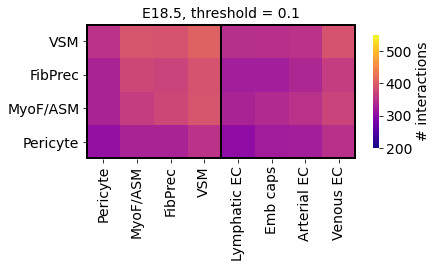

In [211]:
tmpt = 'E18.5'
path = '/home/yike/phd/YK_thesis/chapter3_figures/'
fig = plot_ninters(dfn1, mcs1, ecs1, tmpt, '0.1')['fig']
fig.savefig(path + tmpt + '.png', dpi=150, bbox_inches='tight')

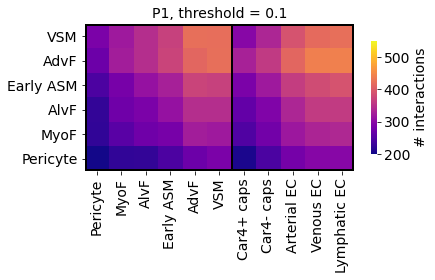

In [212]:
tmpt = 'P1'
path = '/home/yike/phd/YK_thesis/chapter3_figures/'
fig = plot_ninters(dfn2, mcs2, ecs2, tmpt, '0.1')['fig']
fig.savefig(path + tmpt + '.png', dpi=150, bbox_inches='tight')

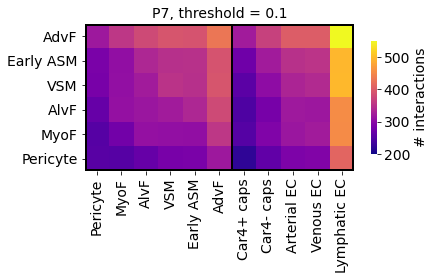

In [213]:
tmpt = 'P7'
path = '/home/yike/phd/YK_thesis/chapter3_figures/'
fig = plot_ninters(dfn3, mcs3, ecs3, tmpt, '0.1')['fig']
fig.savefig(path + tmpt + '.png', dpi=150, bbox_inches='tight')

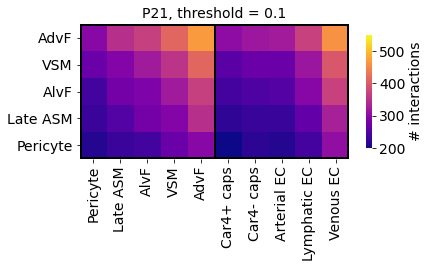

In [214]:
tmpt = 'P21'
path = '/home/yike/phd/YK_thesis/chapter3_figures/'
fig = plot_ninters(dfn4, mcs4, ecs4, tmpt, '0.1')['fig']
fig.savefig(path + tmpt + '.png', dpi=150, bbox_inches='tight')

In [253]:
def plot_diff(dfn, mcs, ecs, title):
    ### index
    from scipy.spatial.distance import pdist 
    distance = pdist(dfn[mcs].values)
    from scipy.cluster.hierarchy import linkage, leaves_list
    lkg = linkage(distance, optimal_ordering=True)
    best_order_mc = leaves_list(lkg) 
    mcs_op = dfn[mcs].index[best_order_mc].tolist()
    if dfn.at[mcs_op[0], mcs_op[0]] > dfn.at[mcs_op[-1], mcs_op[-1]]:
        mcs_op = mcs_op[::-1]

    ### columns
    distance = pdist(dfn.loc[mcs_op[::-1]][ecs].T.values) 
    lkg = linkage(distance, optimal_ordering=True)
    best_order_ec = leaves_list(lkg) 
    ecs_op = dfn.loc[mcs_op][ecs].columns[best_order_ec].tolist()
    if dfn.at[mcs_op[-1], ecs_op[0]] > dfn.at[mcs_op[0], ecs_op[-1]]:
        ecs_op = ecs_op[::-1]

    abbs = {
        'Pericyte': 'Pericyte',
        'Myofibroblast and smooth muscle precursor': 'MyoF/ASM',
        'Fibroblast precursor': 'FibPrec', 
        'Myofibroblast': 'MyoF',
        'Vascular smooth muscle': 'VSM',
        'Nonproliferative embryonic EC': 'Emb caps',
        'Arterial EC': 'Arterial EC', 
        'Venous EC': 'Venous EC', 
        'Lymphatic EC': 'Lymphatic EC',
        'Car4+ capillaries': 'Car4+ caps',
        'Early Car4- capillaries': 'Car4- caps',
        'Late Car4- capillaries': 'Car4- caps',
        'Early airway smooth muscle': 'Early ASM',
        'Airway smooth muscle': 'Late ASM', 
        'Alveolar fibroblast': 'AlvF',
        'Adventitial fibroblast': 'AdvF', 
        'Early alveolar fibroblast': 'AlvF',
        'Early adventitial fibroblast': 'AdvF',    
    }

    fig, ax = plt.subplots()
    rcParams['font.size']
    sns.heatmap(dfn.loc[mcs_op[::-1]][mcs_op + ecs_op], square=True, cmap='vlag', center=0,
                cbar_kws={'shrink':0.5, 'label':'Change in number\nof interactions [%]'}, vmin=-20, vmax=60,
                ax=ax)

    for x in [0, len(mcs+ecs)]:
        ax.axvline(x, c='k', lw=4)
    ax.axvline(len(mcs), c='k', lw=2)
    for y in [0, len(mcs)]:
        ax.axhline(y, c='k', lw=4)

    xticklabels = [abbs[i] for i in [j.get_text() for j in ax.get_xticklabels()]]
    ax.set_xticklabels(xticklabels)

    yticklabels = [abbs[i] for i in [j.get_text() for j in ax.get_yticklabels()]]
    ax.set_yticklabels(yticklabels)
    
    ax.set_title(f'{title}', fontsize=14)
    
    return {'fig': fig, 'ax': ax}

In [251]:
# compute interactions at different timepoints with threshold as 20 %
ex_cts = {
'Pericyte': 'Pericyte', 
'Myofibroblast': 'Myofibroblast and smooth muscle precursor',
'Early airway smooth muscle': 'Myofibroblast and smooth muscle precursor', 
'Early alveolar fibroblast': 'Fibroblast precursor', 
'Early adventitial fibroblast': 'Fibroblast precursor', 
'Vascular smooth muscle': 'Vascular smooth muscle',
'Car4+ capillaries': 'Nonproliferative embryonic EC',
'Early Car4- capillaries': 'Nonproliferative embryonic EC',
'Arterial EC': 'Arterial EC', 
'Venous EC': 'Venous EC', 
'Lymphatic EC': 'Lymphatic EC',
}

path = '/home/yike/phd/neonatal_ lung/jupyter notebook/excels/thesis/'
df1 = pd.read_csv(path + 'E18.50.2' + '.tsv', sep='\t', index_col=['Cell_express_a', 'Cell_express_b'])
df2 = pd.read_csv(path + 'P70.2' + '.tsv', sep='\t', index_col=['Cell_express_a', 'Cell_express_b'])
    
diff = pd.DataFrame([], index=mcs3, columns=mcs3+ecs3)
for ct1 in mcs3:
    for ct2 in mcs3 + ecs3:
        df1i = df1.loc[ex_cts[ct1], ex_cts[ct2]] # E18.5
        df2i = df2.loc[ct1, ct2] # P7      
        diff.at[ct1, ct2] =  (df2i[~ df2i.duplicated()].shape[0] - df1i[~ df1i.duplicated()].shape[0]) * 100 / df1i[~ df1i.duplicated()].shape[0]
diff = diff.apply(pd.to_numeric)        

<ipython-input-251-7e9a3761c259>:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  df1i = df1.loc[ex_cts[ct1], ex_cts[ct2]] # E18.5
<ipython-input-251-7e9a3761c259>:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2i = df2.loc[ct1, ct2] # P7


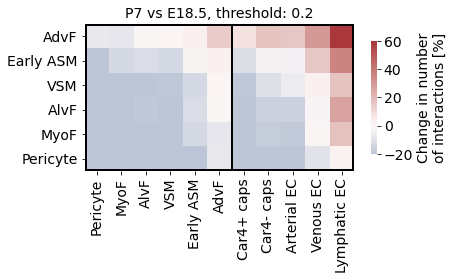

In [254]:
fig = plot_diff(diff, mcs3, ecs3, 'P7 vs E18.5, threshold: 0.2')['fig']
path = '/home/yike/phd/YK_thesis/chapter3_figures/'
fig.savefig(path + 'diff0.2.png', dpi=150, bbox_inches='tight')

### pericytes and EC types

In [259]:
abbs = {
    'Pericyte': 'Pericyte',
    'Myofibroblast and smooth muscle precursor': 'MyoF/ASM',
    'Fibroblast precursor': 'FibPrec', 
    'Myofibroblast': 'MyoF',
    'Vascular smooth muscle': 'VSM',
    'Nonproliferative embryonic EC': 'Emb caps',
    'Arterial EC': 'Arterial EC', 
    'Venous EC': 'Venous EC', 
    'Lymphatic EC': 'Lymphatic EC',
    'Car4+ capillaries': 'Car4+ caps',
    'Early Car4- capillaries': 'Car4- caps',
    'Late Car4- capillaries': 'Car4- caps',
    'Car4- capillaries': 'Car4- caps',
    'Early airway smooth muscle': 'Early ASM',
    'Airway smooth muscle': 'Late ASM', 
    'Alveolar fibroblast': 'AlvF',
    'Adventitial fibroblast': 'AdvF', 
    'Early alveolar fibroblast': 'AlvF',
    'Early adventitial fibroblast': 'AdvF',    
}

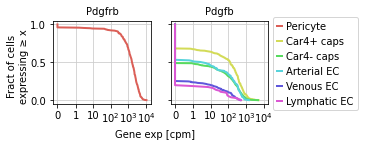

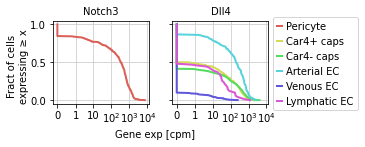

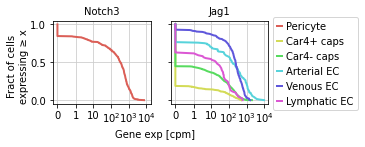

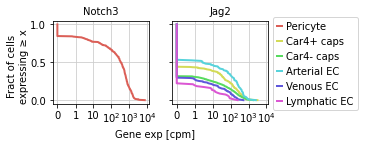

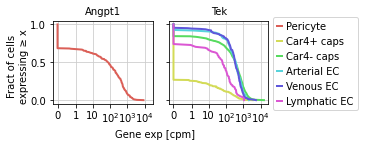

In [347]:
import matplotlib.lines as mlines
inters=[['Pdgfb', 'Pdgfrb'],
        ['Dll4', 'Notch3'], ['Jag1', 'Notch3'], ['Jag2', 'Notch3'],
        ['Tek', 'Angpt1']
       ] # [Car4+, pericyte]

adata_dic={}
EC = ['Pericyte', 
      'Car4+ capillaries', 'Car4- capillaries', 
      'Arterial EC', 'Venous EC', 'Lymphatic EC',]
for ct in EC:
    if ct == 'Car4- capillaries':
        adata_dic[ct] = adata[adata.obs['cellSubtype'].isin(['Early Car4- capillaries', 'Late Car4- capillaries'])]
    elif ct == 'Arterial EC':
        adata_dic[ct] = adata[(adata.obs['cellSubtype'].isin(['Arterial EC I', 'Arterial EC II']))]
    else:
        adata_dic[ct] = adata[adata.obs['cellSubtype'].isin([ct])]

colors = {ct: color for ct, color in zip(EC, sns.color_palette('hls', 6))}

for gene1,gene2 in inters:
    fig,axs=plt.subplots(1, 2, figsize=(5, 2), sharex=True, sharey=True)
    # pericyte
    ct = EC[0]
    gene2_ct=adata_dic[ct][:,gene2].X.toarray()[:,0]
    gene2_ct=np.log10(0.1+gene2_ct)
    x=np.sort(gene2_ct)
    y=1-np.linspace(0,1,len(x))
    axs[0].plot(x,y,lw=2, color=colors[ct])
    axs[0].set_title(gene2, fontsize=10)
    
    for ct in EC[1:]:
        gene1_ct1=adata_dic[ct][:,gene1].X.toarray()[:,0]
        gene1_ct1=np.log10(0.1+gene1_ct1)
        x=np.sort(gene1_ct1)
        y=1-np.linspace(0,1,len(x))
        axs[1].plot(x,y,label=abbs[ct],lw=2, color=colors[ct])

    for i in [0, 1]:
        axs[i].set_xticks([np.log10(0 + 0.1)] + [np.log10(10 ** i + 0.1) for i in range(0, 5)])
        axs[i].set_xticklabels(['0', '1', '10', '$10^2$', '$10^3$', '$10^4$'])
        axs[i].tick_params(labelsize=10)
    
    axs[1].set_title(gene1, fontsize=10)
    
    handles, labels = axs[1].get_legend_handles_labels()
    lgd_peri = [mlines.Line2D([], [], label=EC[0], lw=2, color=colors[EC[0]])]
    handles = lgd_peri + handles
    labels = [EC[0]] + labels
    axs[1].legend(handles, labels, bbox_to_anchor=(1,1.1),bbox_transform=axs[1].transAxes,fontsize=10)
    
    fig.text(0.02, 0.5, 'Fract of cells\nexpressing ≥ x',fontsize=10, ha='center', va='center', rotation='vertical')
    fig.text(0.4, 0.02, 'Gene exp [cpm]',fontsize=10, ha='center', va='center')
    fig.tight_layout()
    fig.savefig('/home/yike/phd/YK_thesis/chapter3_figures/'+gene1+'_'+gene2+'_'+'1.png', 
                dpi=150, bbox_inches='tight')

In [378]:
colors = {ct: color for ct, color in zip(EC, sns.color_palette('hls', 6))}

fig,axs_ar = plt.subplots(len(inters), 2, figsize=(5, 1.9 * len(inters)), sharex=True, sharey=True)

for j, (gene1,gene2) in enumerate(inters):
    axs = axs_ar[j]
    
    ct = EC[0]
    gene2_ct=adata_dic[ct][:,gene2].X.toarray()[:,0]
    gene2_ct=np.log10(0.1+gene2_ct)
    x=np.sort(gene2_ct)
    y=1-np.linspace(0,1,len(x))
    axs[0].plot(x,y,lw=2, color=colors[ct])
    axs[0].set_title(gene2, fontsize=10)
    
    for ct in EC[1:]:
        gene1_ct1=adata_dic[ct][:,gene1].X.toarray()[:,0]
        gene1_ct1=np.log10(0.1+gene1_ct1)
        x=np.sort(gene1_ct1)
        y=1-np.linspace(0,1,len(x))
        axs[1].plot(x,y,lw=2, color=colors[ct])

    for i in [0, 1]:
        axs[i].set_xticks([np.log10(0 + 0.1)] + [np.log10(10 ** i + 0.1) for i in range(0, 5)])
        axs[i].set_xticklabels(['0', '1', '10', '$10^2$', '$10^3$', '$10^4$'])
        axs[i].tick_params(labelsize=10)
    
    axs[1].set_title(gene1, fontsize=10)


handles = []
for ct in EC:
    handles.append(mlines.Line2D([], [], label=ct, lw=2, color=colors[ct]))
axs_ar[0, 1].legend(handles, labels, bbox_to_anchor=(1,1), ncol=1, 
                    bbox_transform=axs_ar[0, 1].transAxes,fontsize=10, )

fig.text(0., 0.5, 'Fract of cells expressing ≥ x',fontsize=10, ha='center', va='center', rotation='vertical')
fig.text(0.4, 0.01, 'Gene exp [cpm]',fontsize=10, ha='center', va='center')
fig.tight_layout()
fig.savefig('/home/yike/phd/YK_thesis/chapter3_figures/'+'all_inters.png', 
            dpi=150, bbox_inches='tight')

In [349]:
adata_dic_new = {(key, 'all'): val for key, val in adata_dic.items()}
res = inters_df(adata_dic_new, ['Pericyte'], EC, 0.1, 'all')
res.to_csv('excels/thesis/peri_EC0.1.tsv', sep='\t', index=False)
res = res.set_index(['Cell_express_a', 'Cell_express_b'])

In [404]:
n = []
for ct in EC:
    dfi = res.loc['Pericyte', ct]
    ni = dfi[~ dfi.duplicated()].shape[0]
    n.append(ni)
n = pd.Series(n, index=EC).sort_values()

n_p = n.loc[EC[1:]].sort_values()

<ipython-input-404-12bc89e3f4d9>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  dfi = res.loc['Pericyte', ct]


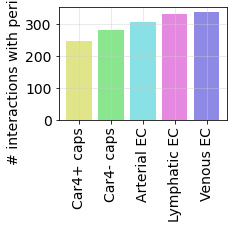

In [413]:
fig, ax = plt.subplots(figsize=[3, 2])
ax.bar(range(len(n_p)), n_p.values, color=[colors[i] for i in n_p.index], alpha=0.7, zorder=0)
ax.set_xticks(range(len(EC[1:])))
ax.set_xticklabels([abbs[ct] for ct in n_p.index], rotation=90)
ax.set_ylabel('# interactions with pericytes')
ax.grid(alpha=0.5)
fig.savefig(path + 'peri_ec_all.png', dpi=150, bbox_inches='tight')